<a href="https://colab.research.google.com/github/Vr18nair/Impact-of-Overfitting-in-Deep-Network---Wildlife-image-classification/blob/main/Overfitting_in_Deep_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow matplotlib seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!cp -r "/content/drive/MyDrive/wildlife_data" "/content/"


In [ ]:
!ls /content/drive/MyDrive/wildlife_data

test  train


In [ ]:
# STEP 3: Explore the dataset structure
import os

base_dir = "wildlife_data"
for root, dirs, files in os.walk(base_dir):
    print(root, "->", len(files), "files")


wildlife_data -> 0 files
wildlife_data/test -> 0 files
wildlife_data/test/elephant -> 60 files
wildlife_data/test/zebra -> 421 files
wildlife_data/test/buffalo -> 90 files
wildlife_data/test/rhino -> 431 files
wildlife_data/train -> 0 files
wildlife_data/train/elephant -> 327 files
wildlife_data/train/zebra -> 331 files
wildlife_data/train/buffalo -> 96 files
wildlife_data/train/rhino -> 321 files


In [ ]:
# STEP 4: Load dataset into TensorFlow pipeline

# Adjust image size for uniformity
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(base_dir, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(base_dir, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Detected classes:", class_names)


Found 539 files belonging to 4 classes.
Found 501 files belonging to 4 classes.
Detected classes: ['buffalo', 'elephant', 'rhino', 'zebra']


In [ ]:
# STEP 5: Normalize pixel values (0–255 → 0–1)
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Cache and prefetch improve performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
# STEP 6: Build a simple CNN prone to overfitting
def build_simple_cnn(num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_simple_cnn(num_classes=len(class_names))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    47,776,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,796,420 (182.33 MB)

 Trainable params: 47,796,420 (182.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# STEP 7: Train model (Overfitting Scenario)
# We use a small dataset or train for more epochs than needed
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds,
    callbacks=[early_stop]
)


Epoch 1/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.3173 - loss: 12.4986 - val_accuracy: 0.6168 - val_loss: 0.9982
Epoch 2/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.6530 - loss: 0.9670 - val_accuracy: 0.7445 - val_loss: 0.7589
Epoch 3/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.7841 - loss: 0.6093 - val_accuracy: 0.7505 - val_loss: 0.7817
Epoch 4/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.9239 - loss: 0.2904 - val_accuracy: 0.7764 - val_loss: 0.8008
Epoch 5/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 89s 5s/step - accuracy: 0.9162 - loss: 0.2265 - val_accuracy: 0.7106 - val_loss: 1.1451
Epoch 6/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.9435 - loss: 0.1485 - val_accuracy: 0.7385 - val_loss: 0.8492
Epoch 7/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.9750 - loss: 0.0806 - val_accuracy: 0.7804 - val_loss: 0.8410


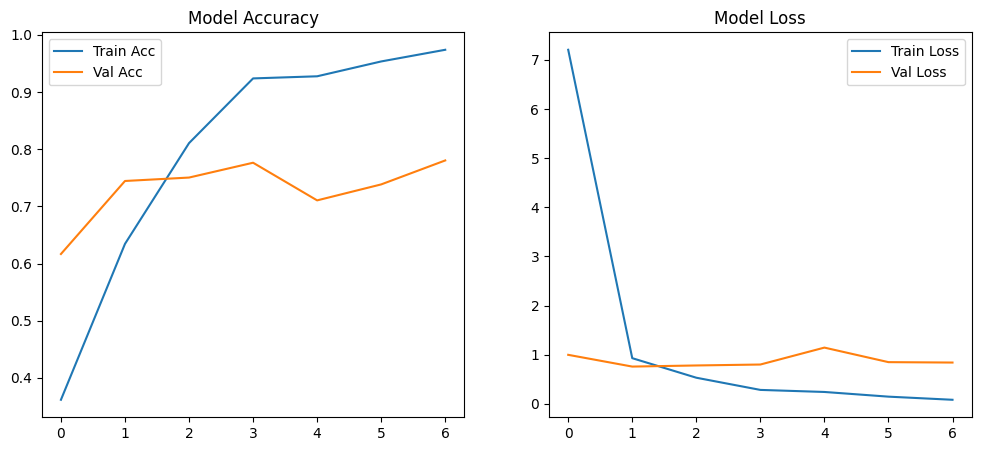

In [ ]:
# STEP 8: Visualize Training vs Validation Accuracy and Loss
def plot_history(hist):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.legend(), plt.title("Model Accuracy")

    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.legend(), plt.title("Model Loss")
    plt.show()

plot_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classification Report:
              precision    recall  f1-score   support

     buffalo       0.00      0.00      0.00        46
    elephant       0.21      0.10      0.14        30
       rhino       0.69      0.90      0.78       215
       zebra       0.86      0.84      0.85       210

    accuracy                           0.74       501
   macro avg       0.44      0.46      0.44       501
weight

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


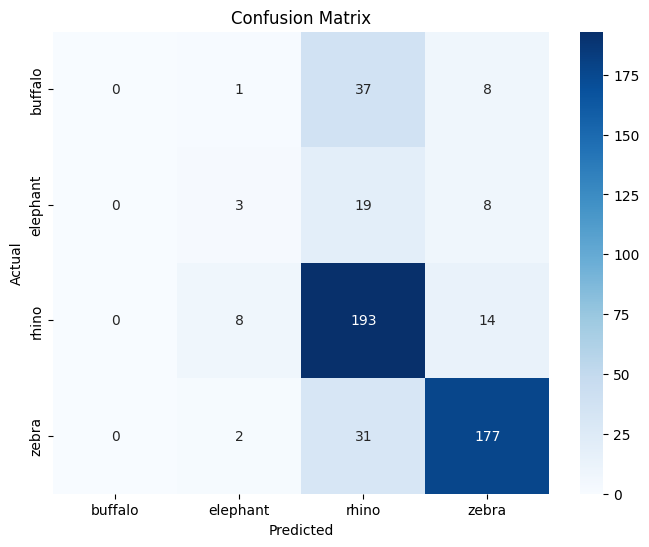

In [ ]:
# STEP 9: Evaluate and Analyze Predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"), plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.2592 - loss: 52.1388 - val_accuracy: 0.4331 - val_loss: 1.3099
Epoch 2/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.3384 - loss: 1.3550 - val_accuracy: 0.4112 - val_loss: 1.3324
Epoch 3/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.3043 - loss: 1.3747 - val_accuracy: 0.4232 - val_loss: 1.3539
Epoch 4/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.3020 - loss: 1.3443 - val_accuracy: 0.3493 - val_loss: 1.3414
Epoch 5/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.2932 - loss: 1.3438 - val_accuracy: 0.3852 - val_loss: 1.3356
Epoch 6/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.3132 - loss: 1.3117 - val_accuracy: 0.4990 - val_loss: 1.2979
Epoch 7/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.3169 - loss: 1.3020 - val_accuracy: 0.4950 - val_loss: 1.2862
Epoch 8/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.3202 - loss: 1.3176 - val_accuracy: 0.5429 - val_loss: 1.2778
Ep

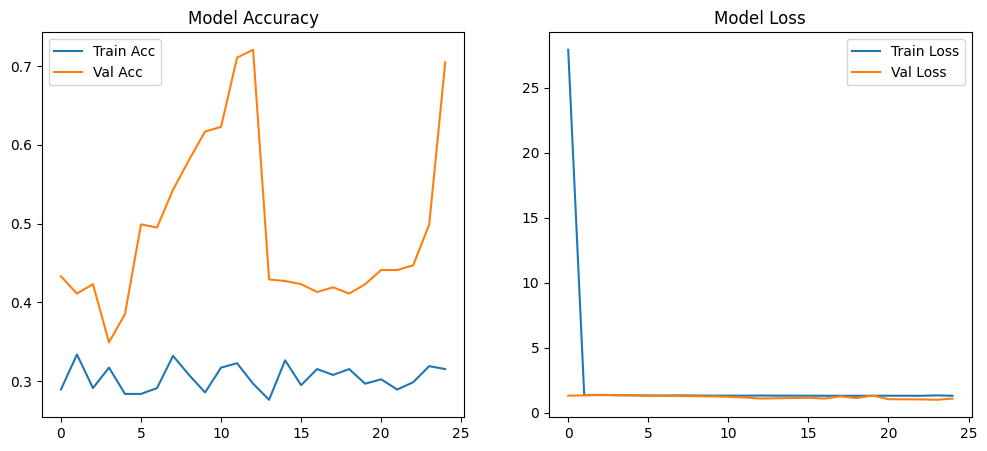

In [ ]:
# 🌱 STEP 10: Mitigate Overfitting with Data Augmentation + Dropout
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1)
])

def build_regularized_cnn(num_classes):
    model = models.Sequential([
        data_augment,
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),  # Regularization
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model2 = build_regularized_cnn(len(class_names))
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds,
    callbacks=[early_stop]
)

plot_history(history2)
